In [9]:
from IPython.display import Image, HTML

# WCT2

## Photorealistic Style Transfer via Wavelet Transforms

Group Members: David Baek, Chenyu Zhang, Siyao Li

## What is Photo Style Transfer?

Photo style transfer is an optimization technique used to modifying the style of an image while still preserving its content. It usually takes two images: a content image and a style image. Style transfer will blend two pictures together so the output image looks like the content image, but have the style of the style image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style image, which are extracted from the images using convolutional networks.

Today we will be introducing a Photo Style Transfer model that maximizes the photorealistic of the output image.

![WCT2](./presentation_photos/demo06.png)
<!-- <p align="left">
  <img width="580" height="384" src="presentation_photos/demo06.png">
</p> -->

This style transfer model is called WCT2 because it is build base on a model called WCT

The WCT formulates stylization as an image reconstruction problem with feature projections.

<img src="./presentation_photos/WCT.png" class="center">

However there is a problem with WCT, which the max-pooling operation in the WCT reduces spatial information in feature maps. 

In the WCT2, it tries to solve the problem by introducing a theoretically sound correction on the downsampling and upsampling operations. The model proposes a wavelet corrected transfer based on whitening and coloring transforms that substitutes the pooling and unpooling operations in the VGG encoder and decoder with wavelet pooling and unpooling.

![WCT2](./presentation_photos/wct2.png)

<!-- <p align="center">
  <img width="1000" height="1000" src="presentation_photos/wct2.png">
</p> -->

We will dive deeper into the topic as we later go through the model

We will first be introducing how to use this model and transfer the images and our own image. It's recommand to do it in a platform with GPU access available, since the transfering process will be pretty time consuming without a GPU.

Create the environment.yml file. Then create and activate your conda environment

name: wct
channels:
    - conda-forge
    - defaults
dependencies: 
    - python=3.6.3
    - numpy=1.14.2
    - pytorch=0.4.1
    - torchvision=0.2.0
    - tqdm=4.45.0
    - pillow=6.2.0
    - jupyterlab
    - rise
    - scipy==1.2.1

conda env create -f environment.yml
conda activate wct

Once you have a directory you’d like to work inside, clone the WCT2 model from github:

In [ ]:
git clone https://github.com/clovaai/WCT2

Navigate into WCT2/ and run the following to output your stylized images:

In [ ]:
python transfer.py \
--option_unpool cat5 \
-a \
--content ./examples/content \
--style ./examples/style \
--content_segment ./examples/content_segment \
--style_segment ./examples/style_segment/
--output ./outputs/ \
--verbose \
--image_size 512

Waiting for it to finish, and it's all done!

However, this will only be transfering the images examples come with the WCT2 model.
If you want to transfer your own images, you can simply name the content and style image the same. Put them into the content folder and style folder correspondingly, and run the command on the last slide again.

First we need to import the necessary libraries, such as os, torch, etc. The WaveEncoder and WaveDecoder is from model.py file from WCT2 model itself.

In [1]:
import os
import tqdm
import argparse

import torch
from torchvision.utils import save_image

from model import WaveEncoder, WaveDecoder

from utils.core import feature_wct
from utils.io import Timer, open_image, load_segment, compute_label_info

And here is a list of image extentions and a helper function that helps to identify if a file is a image.

In [ ]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG',
]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

Next, start defining the WCT2 class. The init function we set up the object with info of device, verbose, encoder, and decoder.

In [ ]:
class WCT2:
    def __init__(self, model_path='./model_checkpoints', transfer_at=['encoder', 'skip', 'decoder'], option_unpool='cat5', device='cuda:0', verbose=False):
        
        # This convert the transfer_at to non_repeated set.
        self.transfer_at = set(transfer_at)
        assert not(self.transfer_at - set(['encoder', 'decoder', 'skip'])), 'invalid transfer_at: {}'.format(transfer_at)
        assert self.transfer_at, 'empty transfer_at'

        # Checks if using GPU      
        self.device = torch.device(device)
        self.verbose = verbose
        # Initialize the encoder and decoder from transfer.py file.
        self.encoder = WaveEncoder(option_unpool).to(self.device)
        self.decoder = WaveDecoder(option_unpool).to(self.device)  
        self.encoder.load_state_dict(torch.load(os.path.join(model_path, 'wave_encoder_{}_l4.pth'.format(option_unpool)), map_location=lambda storage, loc: storage))
        self.decoder.load_state_dict(torch.load(os.path.join(model_path, 'wave_decoder_{}_l4.pth'.format(option_unpool)), map_location=lambda storage, loc: storage))

Some helper functions that will be use while transfering the image.

In [ ]:
    # Print out the verbose.
    def print_(self, msg):
        if self.verbose:
            print(msg)
    
    # Get the corresponding encode or decode layers.
    def encode(self, x, skips, level):
        return self.encoder.encode(x, skips, level)

    def decode(self, x, skips, level):
        return self.decoder.decode(x, skips, level)
    
    # return lists of skips, different layers for encoder and decoder.
    def get_all_feature(self, x):
        skips = {}
        feats = {'encoder': {}, 'decoder': {}}
        for level in [1, 2, 3, 4]:
            x = self.encode(x, skips, level)
            if 'encoder' in self.transfer_at:
                feats['encoder'][level] = x

        if 'encoder' not in self.transfer_at:
            feats['decoder'][4] = x
        for level in [4, 3, 2]:
            x = self.decode(x, skips, level)
            if 'decoder' in self.transfer_at:
                feats['decoder'][level - 1] = x
        return feats, skips

Transfer a image with the sequence of encodeing and decoding layers sequence. The layers starts from the broad characteristics to the finer detail as the layer goes from 1 to 4.

In [ ]:
def transfer(self, content, style, content_segment, style_segment, alpha=1):
        label_set, label_indicator = compute_label_info(content_segment, style_segment)
        content_feat, content_skips = content, {}
        style_feats, style_skips = self.get_all_feature(style)

        wct2_enc_level = [1, 2, 3, 4]
        wct2_dec_level = [1, 2, 3, 4]
        wct2_skip_level = ['pool1', 'pool2', 'pool3']

        for level in [1, 2, 3, 4]:
            content_feat = self.encode(content_feat, content_skips, level)
            if 'encoder' in self.transfer_at and level in wct2_enc_level:
                content_feat = feature_wct(content_feat, style_feats['encoder'][level],
                                           content_segment, style_segment,
                                           label_set, label_indicator,
                                           alpha=alpha, device=self.device)
                self.print_('transfer at encoder {}'.format(level))
        if 'skip' in self.transfer_at:
            for skip_level in wct2_skip_level:
                for component in [0, 1, 2]:  # component: [LH, HL, HH]
                    content_skips[skip_level][component] = feature_wct(content_skips[skip_level][component], style_skips[skip_level][component],
                                                                       content_segment, style_segment,
                                                                       label_set, label_indicator,
                                                                       alpha=alpha, device=self.device)
                self.print_('transfer at skip {}'.format(skip_level))

        for level in [4, 3, 2, 1]:
            if 'decoder' in self.transfer_at and level in style_feats['decoder'] and level in wct2_dec_level:
                content_feat = feature_wct(content_feat, style_feats['decoder'][level],
                                           content_segment, style_segment,
                                           label_set, label_indicator,
                                           alpha=alpha, device=self.device)
                self.print_('transfer at decoder {}'.format(level))
            content_feat = self.decode(content_feat, content_skips, level)
        return content_feat

Next step is a function that transfers all the pictures using the functions defined above.

In [ ]:
def run_bulk(config):
    device = 'cpu' if config.cpu or not torch.cuda.is_available() else 'cuda:0'
    device = torch.device(device)

    transfer_at = set()
    if config.transfer_at_encoder:
        transfer_at.add('encoder')
    if config.transfer_at_decoder:
        transfer_at.add('decoder')
    if config.transfer_at_skip:
        transfer_at.add('skip')

    # The filenames of the content and style pair should match
    fnames = set(os.listdir(config.content)) & set(os.listdir(config.style))

    if config.content_segment and config.style_segment:
        fnames &= set(os.listdir(config.content_segment))
        fnames &= set(os.listdir(config.style_segment))

    for fname in tqdm.tqdm(fnames):
        if not is_image_file(fname):
            print('invalid file (is not image), ', fname)
            continue
        _content = os.path.join(config.content, fname)
        _style = os.path.join(config.style, fname)
        _content_segment = os.path.join(config.content_segment, fname) if config.content_segment else None
        _style_segment = os.path.join(config.style_segment, fname) if config.style_segment else None
        _output = os.path.join(config.output, fname)

        content = open_image(_content, config.image_size).to(device)
        style = open_image(_style, config.image_size).to(device)
        content_segment = load_segment(_content_segment, config.image_size)
        style_segment = load_segment(_style_segment, config.image_size)     
        _, ext = os.path.splitext(fname)

Continues of run_bulk function

In [ ]:
# This is option that user could have to whether transfer all the image or not.
if not config.transfer_all:
            with Timer('Elapsed time in whole WCT: {}', config.verbose):
                postfix = '_'.join(sorted(list(transfer_at)))
                fname_output = _output.replace(ext, '_{}_{}.{}'.format(config.option_unpool, postfix, ext))
                print('------ transfer:', _output)
                wct2 = WCT2(transfer_at=transfer_at, option_unpool=config.option_unpool, device=device, verbose=config.verbose)
                with torch.no_grad():
                    img = wct2.transfer(content, style, content_segment, style_segment, alpha=config.alpha)
                save_image(img.clamp_(0, 1), fname_output, padding=0)
        else:
            for _transfer_at in get_all_transfer():
                with Timer('Elapsed time in whole WCT: {}', config.verbose):
                    postfix = '_'.join(sorted(list(_transfer_at)))
                    fname_output = _output.replace(ext, '_{}_{}.{}'.format(config.option_unpool, postfix, ext))
                    print('------ transfer:', fname)
                    wct2 = WCT2(transfer_at=_transfer_at, option_unpool=config.option_unpool, device=device, verbose=config.verbose)
                    with torch.no_grad():
                        img = wct2.transfer(content, style, content_segment, style_segment, alpha=config.alpha)
                    save_image(img.clamp_(0, 1), fname_output, padding=0)


Last we parse in the user data and call transfer the pictures based on the data.

In [ ]:
if __name__ == '__main__':
    # Command-line argument parser     
    parser = argparse.ArgumentParser()
    parser.add_argument('--content', type=str, default='./examples/content')
    parser.add_argument('--content_segment', type=str, default=None)
    parser.add_argument('--style', type=str, default='./examples/style')
    parser.add_argument('--style_segment', type=str, default=None)
    parser.add_argument('--output', type=str, default='./outputs')
    parser.add_argument('--image_size', type=int, default=512)
    parser.add_argument('--alpha', type=float, default=1)
    parser.add_argument('--option_unpool', type=str, default='cat5', choices=['sum', 'cat5'])
    parser.add_argument('-e', '--transfer_at_encoder', action='store_true')
    parser.add_argument('-d', '--transfer_at_decoder', action='store_true')
    parser.add_argument('-s', '--transfer_at_skip', action='store_true')
    parser.add_argument('-a', '--transfer_all', action='store_true')
    parser.add_argument('--cpu', action='store_true')
    parser.add_argument('--verbose', action='store_true')
    config = parser.parse_args()

    print(config)

    if not os.path.exists(os.path.join(config.output)):
        os.makedirs(os.path.join(config.output))

    '''
    CUDA_VISIBLE_DEVICES=6 python transfer.py --content ./examples/content --style ./examples/style --content_segment ./examples/content_segment --style_segment ./examples/style_segment/ --output ./outputs/ --verbose --image_size 512 -a
    '''
    run_bulk(config)

Next we will be briefly explaining the model.py on the model itself, the model is quite complicated but we can provide a overview of the model.

As mentioned previously, this model can be used from a batch command. Although this can also be used in jupyter, thanks to ! allowing for batch commands, it doesn't utilize any function calls. Solving this issue is slightly counter-intuitive, as the model relies on parsing user data from a command to run the model.

Trying to use this model in a jupyter environment without modifying it would either require using a batch command, or creating an input that the model could parse through to create a compatible argument for run_bulk

It should be mentioned that a modification for this model that doesn't rely on parsing user input will be provided later on

## Using the raw model in Jupyter

First, Import the necessary libraries, and run_bulk

In [ ]:
import argparse
import sys
from transfer import run_bulk

Next dedicate/create three directories to hold the content, style, and output images. For this demonstration, the following directories will be used:
* ./demo/demo_content
* ./demo/demo_style
* ./demo/demo_outputs_new

Consider the following arguments for the model to achieve the desired outputs (taken from the model's documentation).
* `--content`: FOLDER-PATH-TO-CONTENT-IMAGES
* `--content_segment`: FOLDER-PATH-TO-CONTENT-SEGMENT-LABEL-IMAGES
* `--style`: FOLDER-PATH-TO-STYLE-IMAGES
* `--style_segment`: FOLDER-PATH-TO-STYLE-SEGMENT-LABEL-IMAGES
* `--output`: FOLDER-PATH-TO-OUTPUT-IMAGES
* `--image_size`: output image size
* `--alpha`: alpha determines the blending ratio between content and stylized features
* `--option_unpool`: two versions of our model (sum, cat5)
* `-e`, `--transfer_at_encoder`: stylize at the encoder module
* `-d`, `--transfer_at_decoder`: stylize at the decoder module
* `-s`, `--transfer_at_skip`: stylize at the skipped high frequency components
* `-a`, `--transfer_all`: stylize and save for every composition; i.e. power set of \{-e,-d,-s\})
* `--cpu`: run on CPU
* `--verbose`

Finally, use either one of these code batches to obtain the stylizated images. Both batches achieve the same results, with the primary difference being the first one utilizes function calls, while the other is a simple batch command

In [ ]:
if __name__ =='__main__':
    parser = argparse.ArgumentParser()
    # Override sys.argv with arguments for config, would entered as a single command in terminal or command prompt
    sys.argv = ['transfer.py', '--option_unpool','cat5', '-a', '--content', './demo/demo_content', '--style', './demo/demo_style', '--output', './demo/demo_outputs_new', '--verbose', '--image_size', '512']
    parser.add_argument('--content', type=str, default='./examples/content')
    parser.add_argument('--content_segment', type=str, default=None)
    parser.add_argument('--style', type=str, default='./examples/style')
    parser.add_argument('--style_segment', type=str, default=None)
    parser.add_argument('--output', type=str, default='./outputs')
    parser.add_argument('--image_size', type=int, default=512)
    parser.add_argument('--alpha', type=float, default=1)
    parser.add_argument('--option_unpool', type=str, default='cat5', choices=['sum', 'cat5'])
    parser.add_argument('-e', '--transfer_at_encoder', action='store_true')
    parser.add_argument('-d', '--transfer_at_decoder', action='store_true')
    parser.add_argument('-s', '--transfer_at_skip', action='store_true')
    parser.add_argument('-a', '--transfer_all', action='store_true')
    parser.add_argument('--cpu', action='store_true')
    parser.add_argument('--verbose', action='store_true')
    config = parser.parse_args()
    run_bulk(config)

In [ ]:
!python transfer.py --option_unpool cat5 -a --content ./demo/demo_content --style ./demo/demo_style --output ./demo/demo_outputs_new --verbose --image_size 512

## Finding Results

In the output folder, there will be multiple outputs for your desired image(s).

![WCT2](./presentation_photos/fileNames.png)

<!-- <p align="center">
  <img width="580" height="384" src="presentation_photos/fileNames.png">
</p> -->

The fully stylized image will be the file with cat5_decoder_encoder_skip

![WCT2](./presentation_photos/demo07L.png)
<!-- <p align="left">
  <img width="580" height="384" src="presentation_photos/demo07L.png">
</p> -->

## The stylization module

The module is the photo stylization and visualization module. It can be accessed via either importing from jupyter lab/notebook or through the console directly

## Using the module in jupyter lab

In order to use the module in jupyter lab, the user need to import the function visual.process_image
this function has three variables
    content: the content image(s), this can be the path to a specific image or a folder. 
            If the path is a folder, all imgaes in that directory will be processed.
    style: the style image, this must be the path to an image
    optput: the output path, all processed images will be stored under that directory

The following block is the declearaation of the function

In [5]:
def process_image(content: str, style: str, output: str): ...

This is an example of how to use the use the module.

The show_image function is a helper function that can be used to display images

Resize image: (803,538)->(803,538)
Resize image: (960,540)->(960,540)
Elapsed time in stylization: 21.930280
Elapsed time in propagation: 97.929051
Resize image: (500,319)->(500,319)
Resize image: (960,540)->(960,540)
Elapsed time in stylization: 5.018364
Elapsed time in propagation: 20.616880
./results/processed_content2.jpeg
./results/processed_content1.png


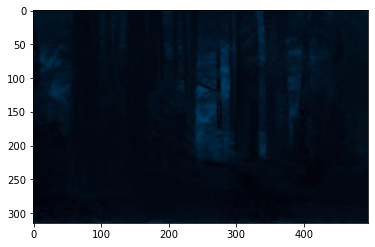

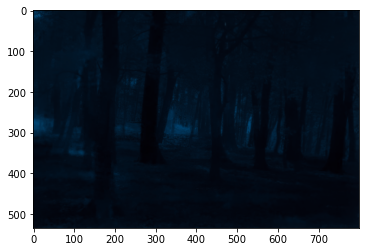

In [4]:
from visual import process_image, show_image

content_path = './images/content/'
style_path = './images/style/style1.png'
output_path = './results/'
# show_image(content_path)
process_image(content_path, style_path, output_path)
# show_image(output_path)

## Using the module in the console

This module can also be accessed via console directly with the following command

In [ ]:
!python visual.py

This command can have three optional arguments (which all have default value) to set the path
* `--content`: the path to content image or directory, default to "./images/content/"
* `--style`: the path to style image, default to "./images/style/style.png"
* `--output`: the path to output directory, default to "./results/"
The following is the main part of the module

Which means if the user doesn't add any argument, it's equivalent to the following command

In [ ]:
!python visual.py --content ./images/content/ --style ./images/style/style.png --output ./results/

In [ ]:
The following is the __main__ of the module

In [ ]:
if __name__ =='__main__':
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--content", default="./images/content/", 
                        help="the source of content images, can be a folder or a specific image")
    parser.add_argument("--style", default="./images/style/style.png", 
                        help="the source of style image, must be an image")
    parser.add_argument("--output", default="./results/", 
                        help="the output path of images, must be a folder")
    args = parser.parse_args()
    
    process_image(args.content, args.style, args.output)

    print('Done!')

The following will be a demonstration of the input images and output images
The title argument in show_image function adds a title to the axis

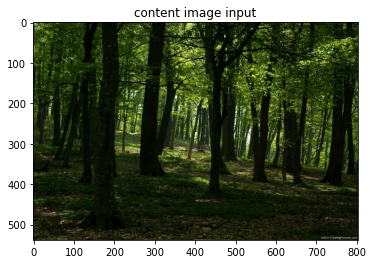

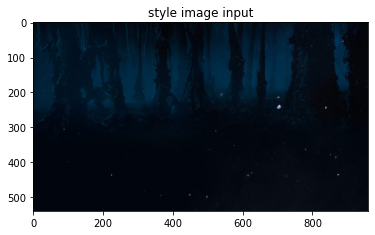

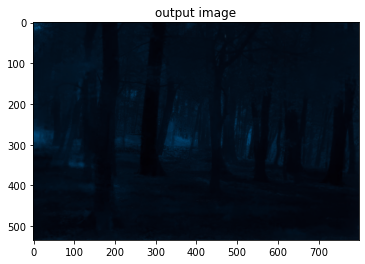

In [2]:
from visual import show_image

show_image('./images/content/content1.png', title='content image input')
show_image('./images/style/style.png', title="style image input")
show_image('./results/processed_content1.png', title="output image")

## Works Cited

Jaejun Yoo, Youngjung Uh, Sanghyuk Chun, Byeongkyu Kang, Jung-Woo Ha. Photorealistic Style Transfer via Wavelet Transforms. https://arxiv.org/pdf/1903.09760.pdf, 2019

Yijun Li, Ming-Yu Liu, Xueting Li, Ming-Hsuan Yang, and Jan Kautz. A closed-form solution to photorealistic image stylization. https://arxiv.org/pdf/1802.06474.pdf, 2018